In [3]:
# Psychological Analysis of LLM Syllogism Reasoning Performance
# Standard research pipeline: descriptive stats -> accuracy analysis -> error analysis -> statistical tests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")


Libraries loaded successfully!


In [4]:
# 1. Data Loading and Preprocessing
df = pd.read_csv('results/all_models_combined_direct_extracted.csv')

# Fix typo in abstraction column: replace 'nocne' with 'nonce'

before_count = (df['abstraction'] == 'nocne').sum()
if before_count > 0:
    print(f"Found {before_count} rows with 'nocne' in abstraction column, replacing with 'nonce'...")
    df['abstraction'] = df['abstraction'].replace('nocne', 'nonce')
    # Save the corrected file
    df.to_csv('results/all_models_combined_direct_extracted.csv', index=False)
    print(f"✓ File saved with corrections")

print(f"\nTotal samples: {len(df)}")
print(f"Models: {df['model'].unique()}")
print(f"\nData shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nUnique abstraction values: {df['abstraction'].unique()}")
print(f"\nFirst few rows:")
df.head()



Total samples: 208
Models: ['Llama-3.1-8B-Instruct' 'Qwen2.5-7B-Instruct'
 'Ministral-8B-Instruct-2410' 'DeepSeek-R1-Distill-Llama-8B']

Data shape: (208, 12)

Columns: ['test_id', 'premise1', 'premise2', 'conclusion', 'correct_validity', 'form', 'abstraction', 'plausibility', 'model', 'llm_answer', 'time', 'output']

Unique abstraction values: ['nonce' 'letter' 'concrete']

First few rows:


,test_id,premise1,premise2,conclusion,correct_validity,form,abstraction,plausibility,model,llm_answer,time,output
0,1,Some swawks are draphs,All swawks are kisques,Some kisques are draphs,valid,Disamis,nonce,NaN,Llama-3.1-8B-Instruct,invalid,4.647,"To evaluate the syllogism, let's break it down..."
1,2,All Q are B,Some Q are S,Some S are B,valid,Datisi,letter,NaN,Llama-3.1-8B-Instruct,valid,4.705,"To evaluate this syllogism, we need to check i..."
2,3,All gheens are thwanks,Some chorse are gheens,Some chorse are thwanks,valid,Darii,nonce,NaN,Llama-3.1-8B-Instruct,valid,3.319,"To evaluate this syllogism, we need to check i..."
3,4,All K are H,Some G are H,Some G are K,invalid,Darii,letter,NaN,Llama-3.1-8B-Instruct,valid,2.712,"To evaluate this syllogism, we need to check i..."
4,5,Thinch is in blaith,Blaith is in swern,"Therefore, thinch is in swern",valid,Sunny,nonce,NaN,Llama-3.1-8B-Instruct,invalid,4.187,"To evaluate this syllogism, we need to check i..."


In [5]:
# 2. Data Cleaning and Preparation
# Create correctness column
df['is_correct'] = (df['llm_answer'] == df['correct_validity']).astype(int)

# Handle missing values
print("Missing values:")
print(df.isnull().sum())
print(f"\nUnique llm_answer values: {df['llm_answer'].unique()}")
print(f"Unique correct_validity values: {df['correct_validity'].unique()}")

# Summary statistics
print(f"\n=== Descriptive Statistics ===")
print(f"Total samples: {len(df)}")
print(f"Overall accuracy: {df['is_correct'].mean():.3f}")
print(f"Models tested: {df['model'].nunique()}")
print(f"Unique syllogisms: {df['test_id'].nunique()}")


Missing values:
test_id              0
premise1             0
premise2             0
conclusion           0
correct_validity     0
form                 0
abstraction          0
plausibility        80
model                0
llm_answer           0
time                 0
output               0
is_correct           0
dtype: int64

Unique llm_answer values: ['invalid' 'valid' 'parse_error']
Unique correct_validity values: ['valid' 'invalid']

=== Descriptive Statistics ===
Total samples: 208
Overall accuracy: 0.668
Models tested: 4
Unique syllogisms: 52


=== Model Performance Comparison ===
                              Accuracy  Correct  Total  Avg_Time
model                                                           
Qwen2.5-7B-Instruct              0.712       37     52     1.631
Ministral-8B-Instruct-2410       0.692       36     52     1.474
DeepSeek-R1-Distill-Llama-8B     0.654       34     52    12.279
Llama-3.1-8B-Instruct            0.615       32     52     3.333


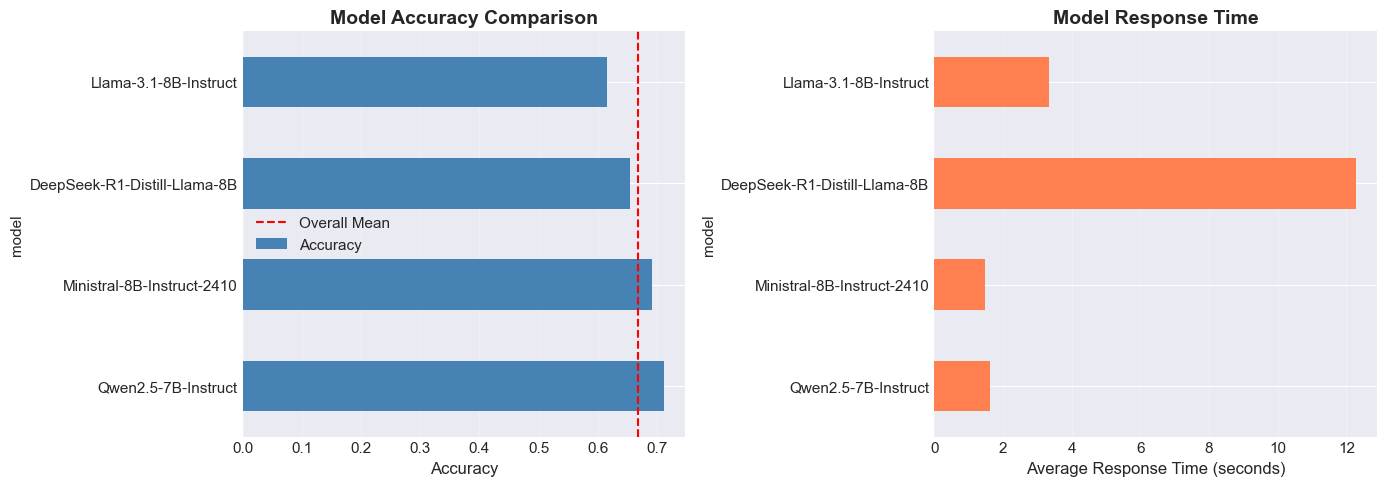

In [6]:
# 3. Model Performance Comparison (Main Analysis)
model_performance = df.groupby('model').agg({
    'is_correct': ['mean', 'sum', 'count'],
    'time': 'mean'
}).round(3)

model_performance.columns = ['Accuracy', 'Correct', 'Total', 'Avg_Time']
model_performance = model_performance.sort_values('Accuracy', ascending=False)

print("=== Model Performance Comparison ===")
print(model_performance)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy by model
model_performance['Accuracy'].plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].axvline(x=df['is_correct'].mean(), color='red', linestyle='--', label='Overall Mean')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)

# Response time by model
model_performance['Avg_Time'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_xlabel('Average Response Time (seconds)', fontsize=12)
axes[1].set_title('Model Response Time', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


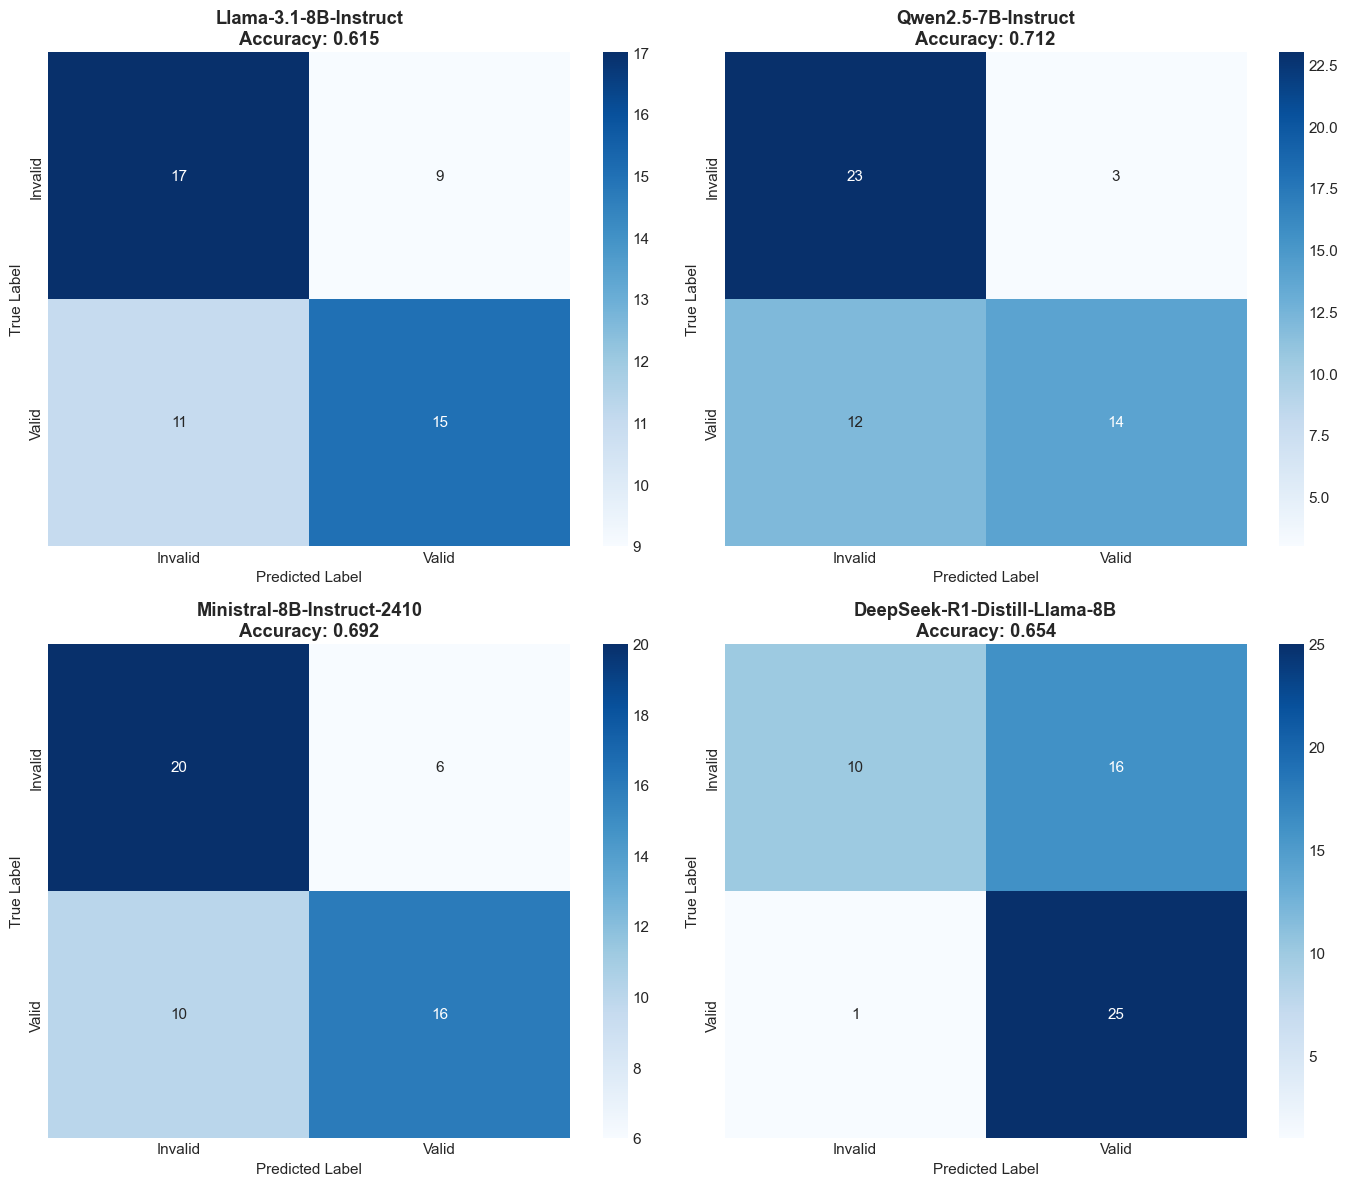


=== Detailed Classification Report ===

Llama-3.1-8B-Instruct:
              precision    recall  f1-score   support

     invalid       0.61      0.65      0.63        26
       valid       0.62      0.58      0.60        26

    accuracy                           0.62        52
   macro avg       0.62      0.62      0.61        52
weighted avg       0.62      0.62      0.61        52


Qwen2.5-7B-Instruct:
              precision    recall  f1-score   support

     invalid       0.66      0.88      0.75        26
       valid       0.82      0.54      0.65        26

    accuracy                           0.71        52
   macro avg       0.74      0.71      0.70        52
weighted avg       0.74      0.71      0.70        52


Ministral-8B-Instruct-2410:
              precision    recall  f1-score   support

     invalid       0.67      0.77      0.71        26
       valid       0.73      0.62      0.67        26

    accuracy                           0.69        52
   macro avg 

In [7]:
# 4. Confusion Matrix Analysis (Error Pattern Analysis)
from sklearn.metrics import confusion_matrix, classification_report

# Create confusion matrix for each model
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, model in enumerate(df['model'].unique()):
    model_df = df[df['model'] == model]
    
    # Map to binary: valid=1, invalid=0
    y_true = (model_df['correct_validity'] == 'valid').astype(int)
    y_pred = (model_df['llm_answer'] == 'valid').astype(int)
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Invalid', 'Valid'],
                yticklabels=['Invalid', 'Valid'])
    axes[idx].set_title(f'{model}\nAccuracy: {model_df["is_correct"].mean():.3f}', 
                        fontweight='bold')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Classification report
print("\n=== Detailed Classification Report ===")
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    y_true = model_df['correct_validity']
    y_pred = model_df['llm_answer']
    print(f"\n{model}:")
    print(classification_report(y_true, y_pred, zero_division=0))


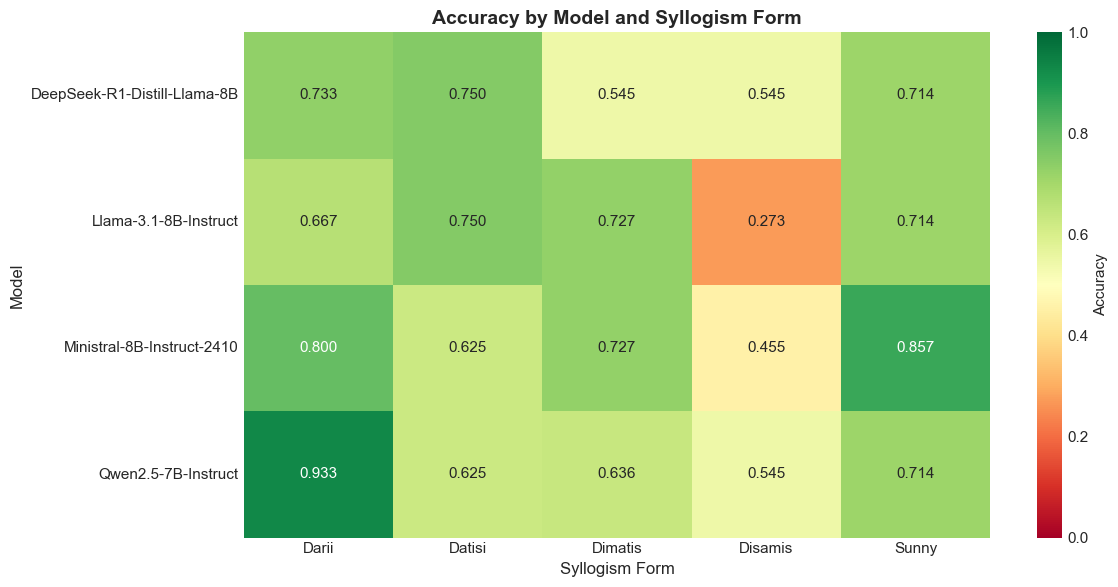


=== Form Performance Summary ===
             mean       std  count
Form                              
Darii    0.783333  0.113855      4
Datisi   0.687500  0.072169      4
Dimatis  0.659091  0.087039      4
Disamis  0.454545  0.128565      4
Sunny    0.750000  0.071429      4

=== Statistical Test: Form Effect ===
One-way ANOVA: F(4, 203) = 3.540, p = 0.0081, η² = 0.0652
** Significant form effect (p < 0.05)

=== Model × Form Interaction Analysis ===
                     sum_sq     df         F    PR(>F)
C(model)           0.283654    3.0  0.428402  0.732881
C(form)            3.006789    4.0  3.405865  0.010241
C(model):C(form)   1.327277   12.0  0.501147  0.912221
Residual          41.492857  188.0       NaN       NaN

No significant Model × Form interaction (p = 0.9122)


In [8]:
# 5. Performance by Syllogism Form (Form Analysis)
if 'form' in df.columns:
    form_performance = df.groupby(['model', 'form']).agg({
        'is_correct': 'mean',
        'test_id': 'count'
    }).reset_index()
    form_performance.columns = ['Model', 'Form', 'Accuracy', 'Count']
    
    # Pivot for heatmap
    form_pivot = form_performance.pivot(index='Model', columns='Form', values='Accuracy')
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(form_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                vmin=0, vmax=1, cbar_kws={'label': 'Accuracy'})
    plt.title('Accuracy by Model and Syllogism Form', fontsize=14, fontweight='bold')
    plt.ylabel('Model', fontsize=12)
    plt.xlabel('Syllogism Form', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    print("\n=== Form Performance Summary ===")
    print(form_performance.groupby('Form')['Accuracy'].agg(['mean', 'std', 'count']))
    
    # Statistical test for form effect (One-way ANOVA)
    print("\n=== Statistical Test: Form Effect ===")
    form_groups = [df[df['form'] == form]['is_correct'].values for form in df['form'].unique()]
    if len(form_groups) > 1:
        f_stat, p_val = stats.f_oneway(*form_groups)
        
        # Calculate eta-squared
        ss_between = sum(len(group) * (group.mean() - df['is_correct'].mean())**2 for group in form_groups)
        ss_total = ((df['is_correct'] - df['is_correct'].mean())**2).sum()
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        print(f"One-way ANOVA: F({len(form_groups)-1}, {len(df)-len(form_groups)}) = {f_stat:.3f}, p = {p_val:.4f}, η² = {eta_squared:.4f}")
        if p_val < 0.05:
            print("** Significant form effect (p < 0.05)")
        else:
            print("No significant form effect (p >= 0.05)")
    
    # Model × Form interaction (if significant)
    print("\n=== Model × Form Interaction Analysis ===")
    try:
        form_ols = ols('is_correct ~ C(model) + C(form) + C(model):C(form)', data=df).fit()
        form_anova = anova_lm(form_ols, typ=2)
        print(form_anova[['sum_sq', 'df', 'F', 'PR(>F)']])
        
        if 'C(model):C(form)' in form_anova.index:
            interaction_p = form_anova.loc['C(model):C(form)', 'PR(>F)']
            if interaction_p < 0.05:
                print(f"\n** Significant Model × Form interaction (p = {interaction_p:.4f})")
            else:
                print(f"\nNo significant Model × Form interaction (p = {interaction_p:.4f})")
    except Exception as e:
        print(f"Error in interaction analysis: {e}")


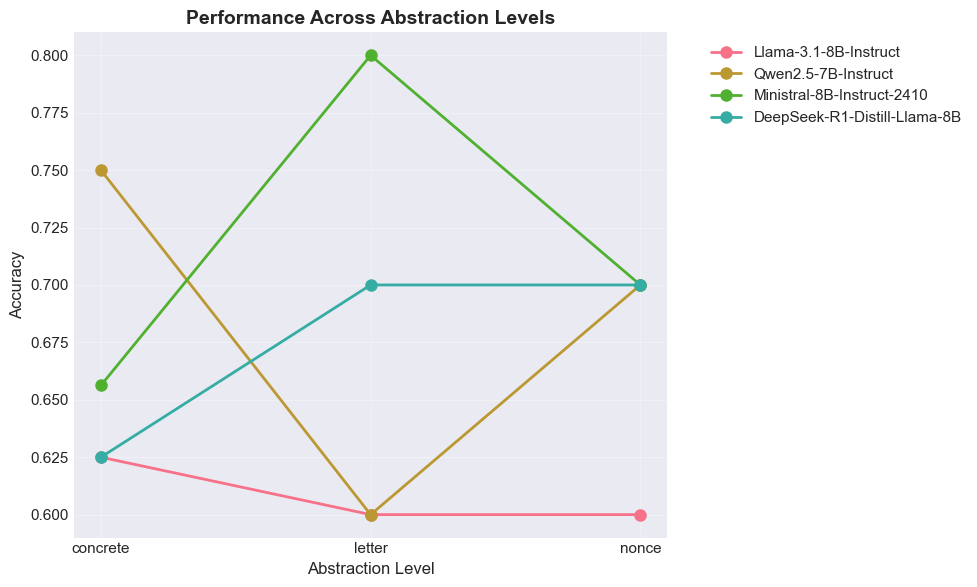


=== Abstraction Performance Summary ===
                 mean       std  count
Abstraction                           
concrete     0.664062  0.059155      4
letter       0.675000  0.095743      4
nonce        0.675000  0.050000      4

=== Statistical Test: Abstraction Effect ===
One-way ANOVA: F(2, 205) = 0.013, p = 0.9870, η² = 0.0001
No significant abstraction effect (p >= 0.05)

=== Model × Abstraction Interaction Analysis ===
                            sum_sq     df         F    PR(>F)
C(model)                  0.283654    3.0  0.408026  0.747403
C(abstraction)            0.005889    2.0  0.012708  0.987374
C(model):C(abstraction)   0.402284    6.0  0.289336  0.941520
Residual                 45.418750  196.0       NaN       NaN

No significant Model × Abstraction interaction (p = 0.9415)


In [9]:
# 6. Performance by Abstraction Level (
# 
#  Analysis)
if 'abstraction' in df.columns:
    abs_performance = df.groupby(['model', 'abstraction']).agg({
        'is_correct': 'mean',
        'test_id': 'count'
    }).reset_index()
    abs_performance.columns = ['Model', 'Abstraction', 'Accuracy', 'Count']
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    for model in df['model'].unique():
        model_data = abs_performance[abs_performance['Model'] == model]
        ax.plot(model_data['Abstraction'], model_data['Accuracy'], 
               marker='o', label=model, linewidth=2, markersize=8)
    
    ax.set_xlabel('Abstraction Level', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Performance Across Abstraction Levels', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\n=== Abstraction Performance Summary ===")
    print(abs_performance.groupby('Abstraction')['Accuracy'].agg(['mean', 'std', 'count']))
    
    # Statistical test for abstraction effect (One-way ANOVA)
    print("\n=== Statistical Test: Abstraction Effect ===")
    abs_groups = [df[df['abstraction'] == abs_level]['is_correct'].values for abs_level in df['abstraction'].unique()]
    if len(abs_groups) > 1:
        f_stat, p_val = stats.f_oneway(*abs_groups)
        
        # Calculate eta-squared
        ss_between = sum(len(group) * (group.mean() - df['is_correct'].mean())**2 for group in abs_groups)
        ss_total = ((df['is_correct'] - df['is_correct'].mean())**2).sum()
        eta_squared = ss_between / ss_total if ss_total > 0 else 0
        
        print(f"One-way ANOVA: F({len(abs_groups)-1}, {len(df)-len(abs_groups)}) = {f_stat:.3f}, p = {p_val:.4f}, η² = {eta_squared:.4f}")
        if p_val < 0.05:
            print("** Significant abstraction effect (p < 0.05)")
        else:
            print("No significant abstraction effect (p >= 0.05)")
    
    # Model × Abstraction interaction
    print("\n=== Model × Abstraction Interaction Analysis ===")
    try:
        abs_ols = ols('is_correct ~ C(model) + C(abstraction) + C(model):C(abstraction)', data=df).fit()
        abs_anova = anova_lm(abs_ols, typ=2)
        print(abs_anova[['sum_sq', 'df', 'F', 'PR(>F)']])
        
        if 'C(model):C(abstraction)' in abs_anova.index:
            interaction_p = abs_anova.loc['C(model):C(abstraction)', 'PR(>F)']
            if interaction_p < 0.05:
                print(f"\n** Significant Model × Abstraction interaction (p = {interaction_p:.4f})")
            else:
                print(f"\nNo significant Model × Abstraction interaction (p = {interaction_p:.4f})")
    except Exception as e:
        print(f"Error in interaction analysis: {e}")


In [10]:
# 7. Statistical Tests (Psychological Inference Statistics)
print("=== Statistical Tests (Psychological Inference) ===")

# Test 1: One-way ANOVA for Model Differences (F-test)
# This tests if there are significant differences between models in accuracy
print("\n1. One-Way ANOVA: Model Performance Difference")
print("-" * 60)

# Prepare data for ANOVA
model_groups = [df[df['model'] == model]['is_correct'].values for model in df['model'].unique()]
f_stat, p_value_anova = stats.f_oneway(*model_groups)

# Calculate effect size (eta-squared)
ss_between = sum(len(group) * (group.mean() - df['is_correct'].mean())**2 for group in model_groups)
ss_total = ((df['is_correct'] - df['is_correct'].mean())**2).sum()
eta_squared = ss_between / ss_total if ss_total > 0 else 0

print(f"   F-statistic: {f_stat:.4f}")
print(f"   p-value: {p_value_anova:.4f}")
print(f"   Effect size (η²): {eta_squared:.4f}")
if eta_squared < 0.01:
    effect_size_interp = "negligible"
elif eta_squared < 0.06:
    effect_size_interp = "small"
elif eta_squared < 0.14:
    effect_size_interp = "medium"
else:
    effect_size_interp = "large"
print(f"   Effect size interpretation: {effect_size_interp}")

if p_value_anova < 0.05:
    print(f"   Result: Significant difference between models (p = {p_value_anova:.4f})")
else:
    print(f"   Result: No significant difference between models (p = {p_value_anova:.4f})")

# Post-hoc tests with Bonferroni correction (if significant)
if p_value_anova < 0.05:
    print(f"\n   Post-hoc comparisons (Bonferroni corrected, α = 0.05/{len(df['model'].unique()) * (len(df['model'].unique())-1) // 2}):")
    from itertools import combinations
    models = df['model'].unique()
    num_comparisons = len(list(combinations(models, 2)))
    alpha_corrected = 0.05 / num_comparisons
    
    for model1, model2 in combinations(models, 2):
        group1 = df[df['model'] == model1]['is_correct']
        group2 = df[df['model'] == model2]['is_correct']
        t_stat, p_val = stats.ttest_ind(group1, group2)
        
        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(group1)-1)*group1.std()**2 + (len(group2)-1)*group2.std()**2) / (len(group1)+len(group2)-2))
        cohens_d = (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0
        
        sig_marker = " **" if p_val < alpha_corrected else ""
        print(f"     {model1} vs {model2}: t={t_stat:.3f}, p={p_val:.4f}, d={cohens_d:.3f}{sig_marker}")

# Test 2: Two-way ANOVA: Model × Validity interaction
print("\n2. Two-Way ANOVA: Model × Validity Interaction")
print("-" * 60)

if 'correct_validity' in df.columns:
    # Create interaction term
    df['model_validity'] = df['model'].astype(str) + '_' + df['correct_validity'].astype(str)
    
    # Perform two-way ANOVA using linear model
    from statsmodels.formula.api import ols
    from statsmodels.stats.anova import anova_lm
    
    try:
        model_ols = ols('is_correct ~ C(model) + C(correct_validity) + C(model):C(correct_validity)', data=df).fit()
        anova_table = anova_lm(model_ols, typ=2)
        print(anova_table)
        
        # Extract p-values and effect sizes
        print("\n   Key findings:")
        print(f"   - Main effect of Model: F={anova_table.loc['C(model)', 'F']:.3f}, p={anova_table.loc['C(model)', 'PR(>F)']:.4f}")
        print(f"   - Main effect of Validity: F={anova_table.loc['C(correct_validity)', 'F']:.3f}, p={anova_table.loc['C(correct_validity)', 'PR(>F)']:.4f}")
        if 'C(model):C(correct_validity)' in anova_table.index:
            interaction_f = anova_table.loc['C(model):C(correct_validity)', 'F']
            interaction_p = anova_table.loc['C(model):C(correct_validity)', 'PR(>F)']
            print(f"   - Model × Validity Interaction: F={interaction_f:.3f}, p={interaction_p:.4f}", end="")
            if interaction_p < 0.05:
                print(" ** Significant interaction")
            else:
                print(" - No significant interaction")
        
        # Calculate partial eta-squared
        ss_model = anova_table.loc['C(model)', 'sum_sq']
        ss_validity = anova_table.loc['C(correct_validity)', 'sum_sq']
        ss_interaction = anova_table.loc['C(model):C(correct_validity)', 'sum_sq'] if 'C(model):C(correct_validity)' in anova_table.index else 0
        ss_error = anova_table.loc['Residual', 'sum_sq']
        ss_total = ss_model + ss_validity + ss_interaction + ss_error
        
        partial_eta2_model = ss_model / (ss_model + ss_error)
        partial_eta2_validity = ss_validity / (ss_validity + ss_error)
        partial_eta2_interaction = ss_interaction / (ss_interaction + ss_error) if ss_interaction > 0 else 0
        
        print(f"\n   Partial η² (effect sizes):")
        print(f"   - Model: {partial_eta2_model:.4f}")
        print(f"   - Validity: {partial_eta2_validity:.4f}")
        print(f"   - Interaction: {partial_eta2_interaction:.4f}")
        
    except Exception as e:
        print(f"   Error in two-way ANOVA: {e}")
        # Fallback to separate t-tests
        print("\n   Fallback: Individual t-tests (Valid vs Invalid) for each model:")
        validity_performance = df.groupby(['model', 'correct_validity'])['is_correct'].mean().unstack()
        print(validity_performance)
        
        for model in df['model'].unique():
            model_df = df[df['model'] == model]
            valid_acc = model_df[model_df['correct_validity'] == 'valid']['is_correct']
            invalid_acc = model_df[model_df['correct_validity'] == 'invalid']['is_correct']
            
            if len(valid_acc) > 0 and len(invalid_acc) > 0:
                # Check normality (Shapiro-Wilk test)
                if len(valid_acc) <= 50 and len(invalid_acc) <= 50:
                    _, p_norm_valid = stats.shapiro(valid_acc)
                    _, p_norm_invalid = stats.shapiro(invalid_acc)
                    
                # Check variance equality (Levene's test)
                _, p_levene = stats.levene(valid_acc, invalid_acc)
                
                # Perform t-test
                if p_levene > 0.05:
                    t_stat, p_val = stats.ttest_ind(valid_acc, invalid_acc, equal_var=True)
                    test_type = "equal variance"
                else:
                    t_stat, p_val = stats.ttest_ind(valid_acc, invalid_acc, equal_var=False)
                    test_type = "Welch's (unequal variance)"
                
                # Calculate Cohen's d
                pooled_std = np.sqrt(((len(valid_acc)-1)*valid_acc.std()**2 + (len(invalid_acc)-1)*invalid_acc.std()**2) / (len(valid_acc)+len(invalid_acc)-2))
                cohens_d = (valid_acc.mean() - invalid_acc.mean()) / pooled_std if pooled_std > 0 else 0
                
                sig_marker = " **" if p_val < 0.05 else ""
                print(f"     {model}: {test_type}, t={t_stat:.3f}, p={p_val:.4f}, d={cohens_d:.3f}{sig_marker}")

else:
    print("   Validity column not found, skipping interaction analysis.")


=== Statistical Tests (Psychological Inference) ===

1. One-Way ANOVA: Model Performance Difference
------------------------------------------------------------
   F-statistic: 0.4209
   p-value: 0.7382
   Effect size (η²): 0.0062
   Effect size interpretation: negligible
   Result: No significant difference between models (p = 0.7382)

2. Two-Way ANOVA: Model × Validity Interaction
------------------------------------------------------------
                                 sum_sq     df          F        PR(>F)
C(model)                       0.283654    3.0   0.485357  6.928309e-01
C(correct_validity)            0.004808    1.0   0.024679  8.753276e-01
C(model):C(correct_validity)   6.860577    3.0  11.739059  4.069603e-07
Residual                      38.961538  200.0        NaN           NaN

   Key findings:
   - Main effect of Model: F=0.485, p=0.6928
   - Main effect of Validity: F=0.025, p=0.8753
   - Model × Validity Interaction: F=11.739, p=0.0000 ** Significant interaction



=== Error Analysis ===

Error Distribution by Model:
error_type                    Correct  False Negative  False Positive  \
model                                                                   
DeepSeek-R1-Distill-Llama-8B       34               1              16   
Llama-3.1-8B-Instruct              32              11               9   
Ministral-8B-Instruct-2410         36              10               6   
Qwen2.5-7B-Instruct                37              12               3   

error_type                    Parse Error  Total_Errors  Error_Rate  
model                                                                
DeepSeek-R1-Distill-Llama-8B            1            18    0.257143  
Llama-3.1-8B-Instruct                   0            20    0.277778  
Ministral-8B-Instruct-2410              0            16    0.235294  
Qwen2.5-7B-Instruct                     0            15    0.223881  


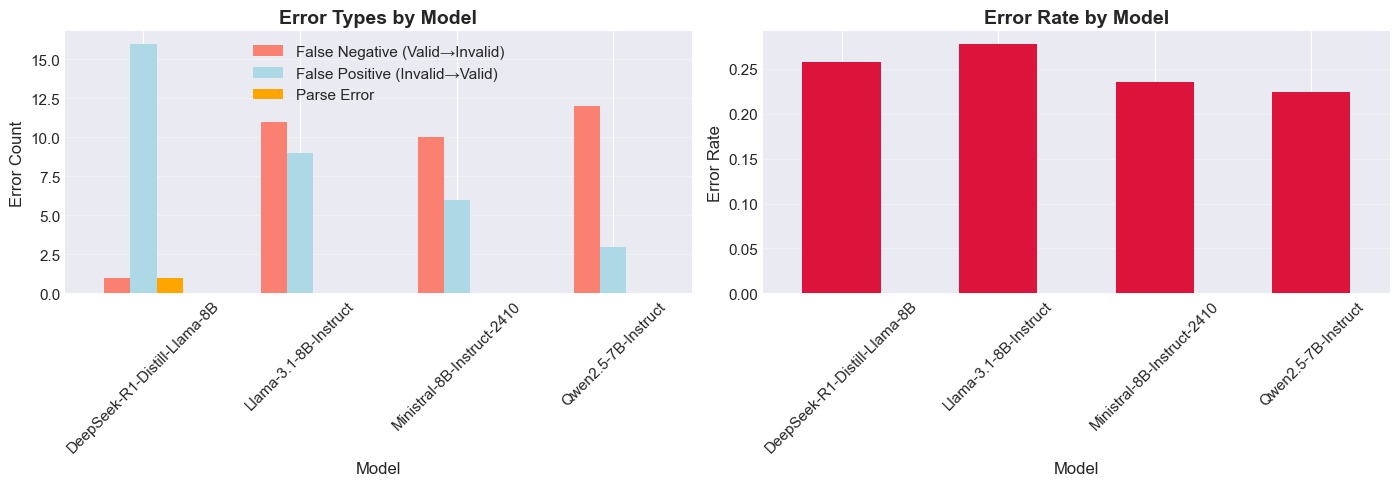

In [11]:
# 8. Error Analysis (Detailed Error Patterns)
print("=== Error Analysis ===")

# Identify error types
df['error_type'] = 'None'
# Handle parse_error cases first
df.loc[df['llm_answer'] == 'parse_error', 'error_type'] = 'Parse Error'
# Then handle False Negative (valid predicted as invalid)
df.loc[(df['correct_validity'] == 'valid') & (df['llm_answer'] == 'invalid'), 'error_type'] = 'False Negative'
# Then handle False Positive (invalid predicted as valid)
df.loc[(df['correct_validity'] == 'invalid') & (df['llm_answer'] == 'valid'), 'error_type'] = 'False Positive'
# Finally, mark correct predictions
df.loc[df['is_correct'] == 1, 'error_type'] = 'Correct'

error_summary = df.groupby(['model', 'error_type']).size().unstack(fill_value=0)
# Calculate total errors including Parse Errors
error_summary['Total_Errors'] = (error_summary.get('False Negative', 0) + 
                                  error_summary.get('False Positive', 0) + 
                                  error_summary.get('Parse Error', 0))
error_summary['Error_Rate'] = error_summary['Total_Errors'] / (error_summary.sum(axis=1))

print("\nError Distribution by Model:")
print(error_summary)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error counts - include Parse Error if it exists
error_cols = ['False Negative', 'False Positive']
if 'Parse Error' in error_summary.columns:
    error_cols.append('Parse Error')
    colors = ['salmon', 'lightblue', 'orange']
    labels = ['False Negative (Valid→Invalid)', 'False Positive (Invalid→Valid)', 'Parse Error']
else:
    colors = ['salmon', 'lightblue']
    labels = ['False Negative (Valid→Invalid)', 'False Positive (Invalid→Valid)']

error_summary[error_cols].plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Error Types by Model', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Error Count', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].legend(labels)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Error rate
error_summary['Error_Rate'].plot(kind='bar', ax=axes[1], color='crimson')
axes[1].set_title('Error Rate by Model', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Error Rate', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


=== Response Time Analysis ===
                                Mean  Median    Std    Min     Max
model                                                             
DeepSeek-R1-Distill-Llama-8B  12.279  11.258  4.586  5.652  20.589
Llama-3.1-8B-Instruct          3.333   3.163  0.854  1.976   6.315
Ministral-8B-Instruct-2410     1.474   1.511  0.454  0.146   2.342
Qwen2.5-7B-Instruct            1.631   1.570  0.556  0.658   3.119


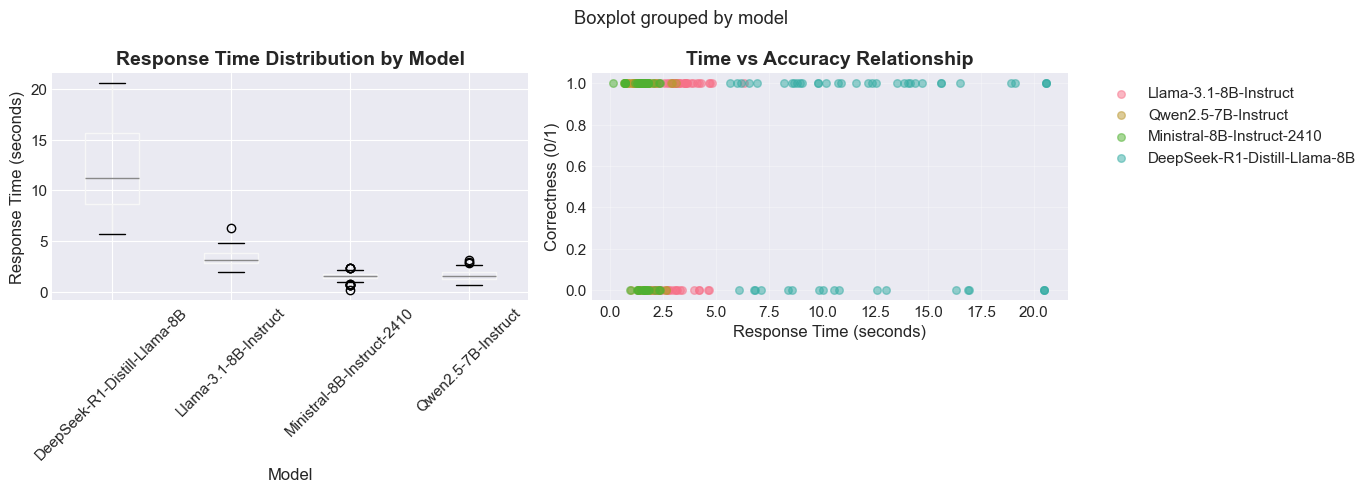


=== Statistical Test: Response Time Differences ===
One-way ANOVA: F(3, 204) = 246.271, p = 0.0000, η² = 0.7836
** Significant time difference between models (p < 0.05)

Post-hoc comparisons (Bonferroni corrected):
  Llama-3.1-8B-Instruct vs Qwen2.5-7B-Instruct: Welch's, t=12.045, p=0.0000, d=2.362 **
  Llama-3.1-8B-Instruct vs Ministral-8B-Instruct-2410: Welch's, t=13.857, p=0.0000, d=2.718 **
  Llama-3.1-8B-Instruct vs DeepSeek-R1-Distill-Llama-8B: Welch's, t=-13.828, p=0.0000, d=-2.712 **
  Qwen2.5-7B-Instruct vs Ministral-8B-Instruct-2410: equal variance, t=1.574, p=0.1186, d=0.309
  Qwen2.5-7B-Instruct vs DeepSeek-R1-Distill-Llama-8B: Welch's, t=-16.621, p=0.0000, d=-3.260 **
  Ministral-8B-Instruct-2410 vs DeepSeek-R1-Distill-Llama-8B: Welch's, t=-16.906, p=0.0000, d=-3.315 **

=== Correlation: Response Time vs Accuracy (Cognitive Load) ===
Llama-3.1-8B-Instruct: r = 0.235, p = 0.0934 - No significant correlation
Qwen2.5-7B-Instruct: r = -0.212, p = 0.1310 - No significant corre

In [12]:
# 9. Response Time Analysis (Cognitive Load Analysis)
print("=== Response Time Analysis ===")

time_stats = df.groupby('model').agg({
    'time': ['mean', 'median', 'std', 'min', 'max']
}).round(3)
time_stats.columns = ['Mean', 'Median', 'Std', 'Min', 'Max']

print(time_stats)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
df.boxplot(column='time', by='model', ax=axes[0])
axes[0].set_title('Response Time Distribution by Model', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Response Time (seconds)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Relationship between time and accuracy
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    axes[1].scatter(model_df['time'], model_df['is_correct'], 
                   alpha=0.5, label=model, s=30)

axes[1].set_xlabel('Response Time (seconds)', fontsize=12)
axes[1].set_ylabel('Correctness (0/1)', fontsize=12)
axes[1].set_title('Time vs Accuracy Relationship', fontsize=14, fontweight='bold')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical test for response time differences
print("\n=== Statistical Test: Response Time Differences ===")
time_groups = [df[df['model'] == model]['time'].values for model in df['model'].unique()]
f_stat, p_val = stats.f_oneway(*time_groups)

# Calculate eta-squared for time
ss_between_time = sum(len(group) * (group.mean() - df['time'].mean())**2 for group in time_groups)
ss_total_time = ((df['time'] - df['time'].mean())**2).sum()
eta_squared_time = ss_between_time / ss_total_time if ss_total_time > 0 else 0

print(f"One-way ANOVA: F({len(time_groups)-1}, {len(df)-len(time_groups)}) = {f_stat:.3f}, p = {p_val:.4f}, η² = {eta_squared_time:.4f}")
if p_val < 0.05:
    print("** Significant time difference between models (p < 0.05)")
    
    # Post-hoc tests
    print("\nPost-hoc comparisons (Bonferroni corrected):")
    models = df['model'].unique()
    num_comparisons = len(list(combinations(models, 2)))
    alpha_corrected = 0.05 / num_comparisons
    
    for model1, model2 in combinations(models, 2):
        group1 = df[df['model'] == model1]['time']
        group2 = df[df['model'] == model2]['time']
        
        # Check variance equality
        _, p_levene = stats.levene(group1, group2)
        if p_levene > 0.05:
            t_stat, p_val_time = stats.ttest_ind(group1, group2, equal_var=True)
            test_type = "equal variance"
        else:
            t_stat, p_val_time = stats.ttest_ind(group1, group2, equal_var=False)
            test_type = "Welch's"
        
        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(group1)-1)*group1.std()**2 + (len(group2)-1)*group2.std()**2) / (len(group1)+len(group2)-2))
        cohens_d = (group1.mean() - group2.mean()) / pooled_std if pooled_std > 0 else 0
        
        sig_marker = " **" if p_val_time < alpha_corrected else ""
        print(f"  {model1} vs {model2}: {test_type}, t={t_stat:.3f}, p={p_val_time:.4f}, d={cohens_d:.3f}{sig_marker}")
else:
    print("No significant time difference between models (p >= 0.05)")

# Correlation between response time and accuracy (cognitive load hypothesis)
print("\n=== Correlation: Response Time vs Accuracy (Cognitive Load) ===")
for model in df['model'].unique():
    model_df = df[df['model'] == model]
    if len(model_df) > 3:  # Need at least 4 points for correlation
        r, p_corr = stats.pearsonr(model_df['time'], model_df['is_correct'])
        print(f"{model}: r = {r:.3f}, p = {p_corr:.4f}", end="")
        if p_corr < 0.05:
            print(" ** Significant correlation")
        else:
            print(" - No significant correlation")


In [21]:
# # 10. Summary Statistics Table (Publication-ready)
# print("=== Summary Statistics for Publication ===")

# summary_table = df.groupby('model').agg({
#     'is_correct': ['mean', 'std', 'count'],
#     'time': ['mean', 'std']
# }).round(3)

# summary_table.columns = ['Accuracy_Mean', 'Accuracy_STD', 'N', 'Time_Mean', 'Time_STD']
# summary_table['Accuracy_CI_95'] = 1.96 * (summary_table['Accuracy_STD'] / np.sqrt(summary_table['N']))
# summary_table['Accuracy_Lower'] = summary_table['Accuracy_Mean'] - summary_table['Accuracy_CI_95']
# summary_table['Accuracy_Upper'] = summary_table['Accuracy_Mean'] + summary_table['Accuracy_CI_95']

# print(summary_table[['Accuracy_Mean', 'Accuracy_Lower', 'Accuracy_Upper', 'N', 'Time_Mean']])

# # Export to CSV for further analysis
# summary_table.to_csv('results/performance_summary_direct.csv')
# print("\nSummary table saved to 'results/performance_summary_direct.csv'")


=== Answer Bias Analysis ===

1. Valid/Invalid Answer Bias:
------------------------------------------------------------

Answer Distribution by Model (All Predictions):
llm_answer                    invalid  parse_error  valid
model                                                    
DeepSeek-R1-Distill-Llama-8B       10            1     41
Llama-3.1-8B-Instruct              28            0     24
Ministral-8B-Instruct-2410         30            0     22
Qwen2.5-7B-Instruct                35            0     17

Ground Truth Distribution:
  Valid: 104 (50.0%)
  Invalid: 104 (50.0%)

Valid/Invalid Bias (Predicted % - Ground Truth %):
                              Predicted_Valid_%  Predicted_Invalid_%  \
DeepSeek-R1-Distill-Llama-8B              78.85                19.23   
Llama-3.1-8B-Instruct                     46.15                53.85   
Ministral-8B-Instruct-2410                42.31                57.69   
Qwen2.5-7B-Instruct                       32.69                67.31  

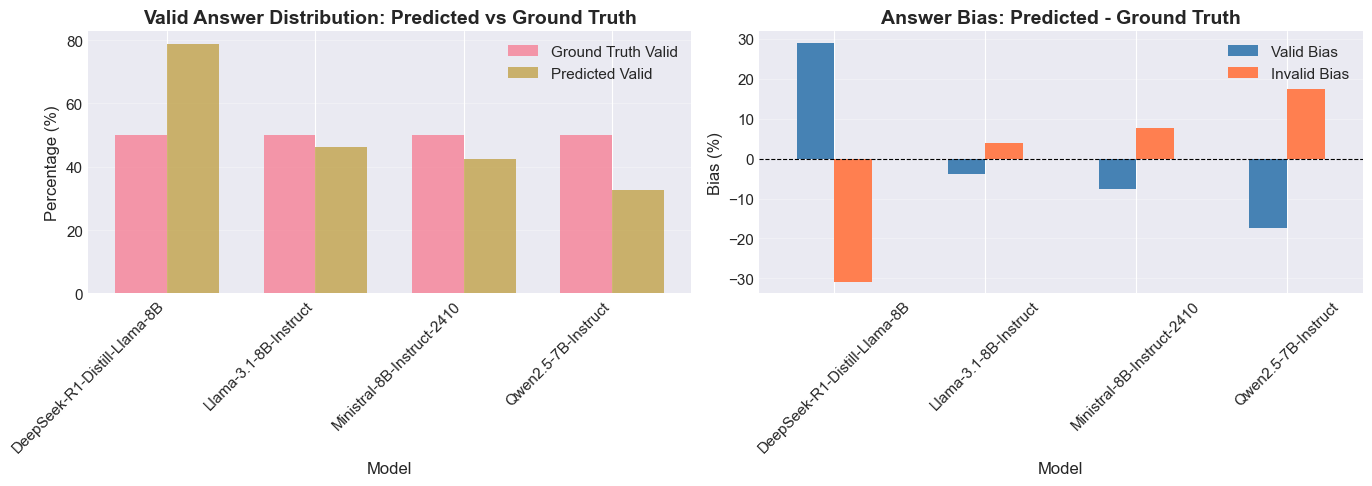


Statistical Test for Valid/Invalid Bias (Chi-square Goodness-of-Fit):
Testing if predicted distribution differs from ground truth distribution
------------------------------------------------------------
  Llama-3.1-8B-Instruct:
    χ²(1) = 0.308, p = 0.5791, Cramér's V = 0.077 (negligible)
    No significant bias (p >= 0.05)

  Qwen2.5-7B-Instruct:
    χ²(1) = 6.231, p = 0.0126, Cramér's V = 0.346 (medium)
    ** Significant bias (p < 0.05)

  Ministral-8B-Instruct-2410:
    χ²(1) = 1.231, p = 0.2673, Cramér's V = 0.154 (small)
    No significant bias (p >= 0.05)

  DeepSeek-R1-Distill-Llama-8B:
    χ²(1) = 18.843, p = 0.0000, Cramér's V = 0.608 (large)
    ** Significant bias (p < 0.05)



2. Plausibility Bias Analysis:
------------------------------------------------------------

Plausibility Distribution in Dataset:
implausible    64
plausible      64
Name: plausibility, dtype: int64

Unique plausibility values: ['implausible' 'plausible']

After filtering:
  Plausible items: 64
 

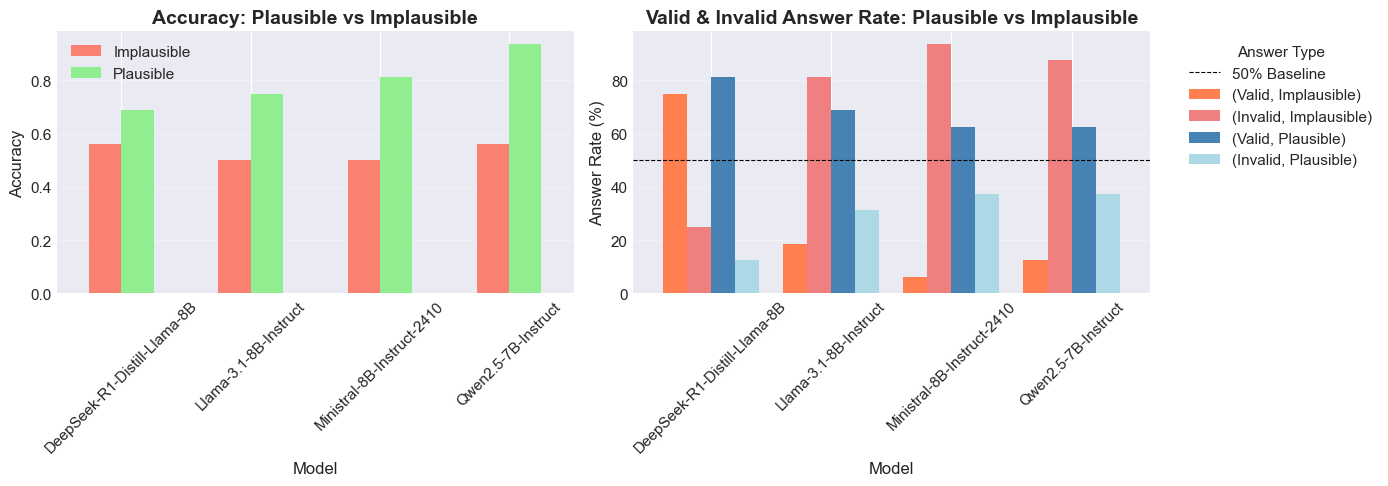


Statistical Test for Plausibility Effect:
------------------------------------------------------------
  Llama-3.1-8B-Instruct (Plausible vs Implausible):
    Welch's t-test: t(30) = 1.464, p = 0.1538
    Cohen's d = 0.518 (medium) - No significant difference (p >= 0.05)

  Qwen2.5-7B-Instruct (Plausible vs Implausible):
    Welch's t-test: t(30) = 2.631, p = 0.0153
    Cohen's d = 0.930 (large) ** Significant difference (p < 0.05)

  Ministral-8B-Instruct-2410 (Plausible vs Implausible):
    Welch's t-test: t(30) = 1.908, p = 0.0666
    Cohen's d = 0.675 (medium) - No significant difference (p >= 0.05)

  DeepSeek-R1-Distill-Llama-8B (Plausible vs Implausible):
    equal variance t-test: t(30) = 0.713, p = 0.4813
    Cohen's d = 0.252 (small) - No significant difference (p >= 0.05)



In [14]:
# 11. Answer Bias Analysis (Valid/Invalid and Plausibility Bias)
print("=== Answer Bias Analysis ===\n")

# 1. Valid/Invalid Bias - Check if models have preference for valid or invalid
print("1. Valid/Invalid Answer Bias:")
print("-" * 60)

# Calculate answer distribution (what models predict regardless of correctness)
answer_distribution = df.groupby(['model', 'llm_answer']).size().unstack(fill_value=0)
print("\nAnswer Distribution by Model (All Predictions):")
print(answer_distribution)

# Calculate baseline (ground truth distribution)
ground_truth_dist = df['correct_validity'].value_counts()
print(f"\nGround Truth Distribution:")
print(f"  Valid: {ground_truth_dist.get('valid', 0)} ({ground_truth_dist.get('valid', 0)/len(df)*100:.1f}%)")
print(f"  Invalid: {ground_truth_dist.get('invalid', 0)} ({ground_truth_dist.get('invalid', 0)/len(df)*100:.1f}%)")

# Calculate bias: difference between predicted distribution and ground truth
if 'valid' in answer_distribution.columns and 'invalid' in answer_distribution.columns:
    print("\nValid/Invalid Bias (Predicted % - Ground Truth %):")
    bias_table = pd.DataFrame()
    for model in answer_distribution.index:
        total = answer_distribution.loc[model].sum()
        pred_valid_pct = (answer_distribution.loc[model, 'valid'] / total * 100) if 'valid' in answer_distribution.columns else 0
        pred_invalid_pct = (answer_distribution.loc[model, 'invalid'] / total * 100) if 'invalid' in answer_distribution.columns else 0
        gt_valid_pct = ground_truth_dist.get('valid', 0) / len(df) * 100
        gt_invalid_pct = ground_truth_dist.get('invalid', 0) / len(df) * 100
        
        bias_table.loc[model, 'Predicted_Valid_%'] = pred_valid_pct
        bias_table.loc[model, 'Predicted_Invalid_%'] = pred_invalid_pct
        bias_table.loc[model, 'Valid_Bias'] = pred_valid_pct - gt_valid_pct
        bias_table.loc[model, 'Invalid_Bias'] = pred_invalid_pct - gt_invalid_pct
    
    print(bias_table.round(2))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Predicted vs Ground Truth distribution
    x = np.arange(len(bias_table))
    width = 0.35
    axes[0].bar(x - width/2, [gt_valid_pct] * len(bias_table), width, label='Ground Truth Valid', alpha=0.7)
    axes[0].bar(x + width/2, bias_table['Predicted_Valid_%'], width, label='Predicted Valid', alpha=0.7)
    axes[0].set_xlabel('Model', fontsize=12)
    axes[0].set_ylabel('Percentage (%)', fontsize=12)
    axes[0].set_title('Valid Answer Distribution: Predicted vs Ground Truth', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(bias_table.index, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)
    
    # Bias visualization
    # Plot with explicit column order and colors to ensure legend matches
    plot_cols = ['Valid_Bias', 'Invalid_Bias']
    plot_colors = ['steelblue', 'coral']
    
    # Plot and get the axes object to extract correct legend order
    ax_plot = bias_table[plot_cols].plot(kind='bar', ax=axes[1], color=plot_colors)
    axes[1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1].set_xlabel('Model', fontsize=12)
    axes[1].set_ylabel('Bias (%)', fontsize=12)
    axes[1].set_title('Answer Bias: Predicted - Ground Truth', fontsize=14, fontweight='bold')
    
    # Get legend labels from the plot in the correct order
    handles, labels = axes[1].get_legend_handles_labels()
    # Map the actual column names to display labels
    label_map = {'Valid_Bias': 'Valid Bias', 'Invalid_Bias': 'Invalid Bias'}
    display_labels = [label_map.get(label, label) for label in labels]
    axes[1].legend(handles, display_labels)
    
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test for bias (chi-square test)
    print("\nStatistical Test for Valid/Invalid Bias (Chi-square Goodness-of-Fit):")
    print("Testing if predicted distribution differs from ground truth distribution")
    print("-" * 60)
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        # Filter out parse_error for this test
        model_df_filtered = model_df[model_df['llm_answer'].isin(['valid', 'invalid'])]
        observed = model_df_filtered['llm_answer'].value_counts().reindex(['valid', 'invalid'], fill_value=0).values
        
        # Expected distribution based on ground truth
        gt_valid_count = ground_truth_dist.get('valid', 0)
        gt_invalid_count = ground_truth_dist.get('invalid', 0)
        total_gt = gt_valid_count + gt_invalid_count
        
        # Normalize expected to match observed total
        observed_total = observed.sum()
        if observed_total > 0 and total_gt > 0:
            expected = np.array([
                (gt_valid_count / total_gt) * observed_total,
                (gt_invalid_count / total_gt) * observed_total
            ])
            
            if expected.sum() > 0 and all(expected > 0):  # Chi-square requires all expected > 0
                chi2, p_val = stats.chisquare(observed, expected)
                
                # Calculate effect size (Cramér's V)
                n = observed_total
                cramers_v = np.sqrt(chi2 / (n * (min(2, 2) - 1))) if n > 0 else 0
                
                print(f"  {model}:")
                print(f"    χ²(1) = {chi2:.3f}, p = {p_val:.4f}, Cramér's V = {cramers_v:.3f}", end="")
                if cramers_v < 0.1:
                    effect_interp = "negligible"
                elif cramers_v < 0.3:
                    effect_interp = "small"
                elif cramers_v < 0.5:
                    effect_interp = "medium"
                else:
                    effect_interp = "large"
                print(f" ({effect_interp})")
                
                if p_val < 0.05:
                    print(f"    ** Significant bias (p < 0.05)")
                else:
                    print(f"    No significant bias (p >= 0.05)")
                print()

# 2. Plausibility Bias - Check if models perform differently on plausible vs implausible syllogisms
print("\n\n2. Plausibility Bias Analysis:")
print("-" * 60)

# Initialize variables for later use
df_plausible = pd.DataFrame()
plausibility_available = False

if 'plausibility' in df.columns:
    # Check plausibility distribution
    plausibility_counts = df['plausibility'].value_counts()
    print("\nPlausibility Distribution in Dataset:")
    print(plausibility_counts)
    
    # Filter out NA values (both NaN and string 'NA')
    df_plausible = df[
        df['plausibility'].notna() & 
        (df['plausibility'].astype(str).str.upper() != 'NA')
    ].copy()
    
    if len(df_plausible) > 0:
        plausibility_available = True
        # Convert to binary if needed (plausible/implausible)
        if df_plausible['plausibility'].dtype == 'object':
            # Check unique values
            unique_plaus = df_plausible['plausibility'].unique()
            print(f"\nUnique plausibility values: {unique_plaus}")
            
            # Create binary column - explicitly handle 'plausible' and 'implausible'
            # Important: check for 'implausible' first to avoid matching it with 'plausible'
            df_plausible['is_plausible'] = df_plausible['plausibility'].astype(str).str.lower().apply(
                lambda x: 1 if x == 'plausible' else (0 if x == 'implausible' else np.nan)
            )
            
            # Remove rows where plausibility is neither 'plausible' nor 'implausible'
            df_plausible = df_plausible[df_plausible['is_plausible'].notna()].copy()
            
            print(f"\nAfter filtering:")
            print(f"  Plausible items: {(df_plausible['is_plausible'] == 1).sum()}")
            print(f"  Implausible items: {(df_plausible['is_plausible'] == 0).sum()}")
            print(f"  Total items analyzed: {len(df_plausible)}")
            
            # Performance by plausibility
            plausibility_performance = df_plausible.groupby(['model', 'is_plausible']).agg({
                'is_correct': 'mean',
                'test_id': 'count'
            }).reset_index()
            plausibility_performance.columns = ['Model', 'Is_Plausible', 'Accuracy', 'Count']
            
            print("\nPerformance by Plausibility:")
            plaus_perf_pivot = plausibility_performance.pivot(index='Model', columns='Is_Plausible', values='Accuracy')
            # Rename columns for clarity
            if 0 in plaus_perf_pivot.columns:
                plaus_perf_pivot = plaus_perf_pivot.rename(columns={0: 'Implausible', 1: 'Plausible'})
            print(plaus_perf_pivot.round(3))
            
            # Show counts
            print("\nCount by Plausibility:")
            plaus_count_pivot = plausibility_performance.pivot(index='Model', columns='Is_Plausible', values='Count')
            if 0 in plaus_count_pivot.columns:
                plaus_count_pivot = plaus_count_pivot.rename(columns={0: 'Implausible', 1: 'Plausible'})
            print(plaus_count_pivot)
            
            # Answer bias by plausibility
            print("\nAnswer Distribution by Plausibility:")
            plausibility_answer_dist = df_plausible.groupby(['model', 'is_plausible', 'llm_answer']).size().unstack(fill_value=0)
            print(plausibility_answer_dist)
            
            # Visualization
            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            
            # Accuracy by plausibility
            plaus_pivot_viz = plausibility_performance.pivot(index='Model', columns='Is_Plausible', values='Accuracy')
            # Rename columns for visualization - handle cases where only one column exists
            rename_dict = {}
            if 0 in plaus_pivot_viz.columns:
                rename_dict[0] = 'Implausible'
            if 1 in plaus_pivot_viz.columns:
                rename_dict[1] = 'Plausible'
            if rename_dict:
                plaus_pivot_viz = plaus_pivot_viz.rename(columns=rename_dict)
            
            # Ensure correct column order if both exist
            plot_cols = []
            plot_colors = []
            plot_labels = []
            if 'Implausible' in plaus_pivot_viz.columns:
                plot_cols.append('Implausible')
                plot_colors.append('salmon')
                plot_labels.append('Implausible')
            if 'Plausible' in plaus_pivot_viz.columns:
                plot_cols.append('Plausible')
                plot_colors.append('lightgreen')
                plot_labels.append('Plausible')
            
            if plot_cols:
                plaus_pivot_viz[plot_cols].plot(kind='bar', ax=axes[0], color=plot_colors)
                axes[0].set_xlabel('Model', fontsize=12)
                axes[0].set_ylabel('Accuracy', fontsize=12)
                axes[0].set_title('Accuracy: Plausible vs Implausible', fontsize=14, fontweight='bold')
                axes[0].legend(plot_labels)
                axes[0].tick_params(axis='x', rotation=45)
                axes[0].grid(axis='y', alpha=0.3)
            else:
                axes[0].text(0.5, 0.5, 'No plausibility data available', 
                            ha='center', va='center', transform=axes[0].transAxes)
                axes[0].set_title('Accuracy: Plausible vs Implausible', fontsize=14, fontweight='bold')
            
            # Valid and Invalid answer rate by plausibility
            answer_rate_by_plaus = df_plausible.groupby(['model', 'is_plausible']).apply(
                lambda x: pd.Series({
                    'Valid_Rate': (x['llm_answer'] == 'valid').sum() / len(x) * 100,
                    'Invalid_Rate': (x['llm_answer'] == 'invalid').sum() / len(x) * 100
                })
            ).reset_index()
            
            # Create separate dataframes for valid and invalid rates
            valid_rate_by_plaus = answer_rate_by_plaus.pivot(index='model', columns='is_plausible', values='Valid_Rate')
            invalid_rate_by_plaus = answer_rate_by_plaus.pivot(index='model', columns='is_plausible', values='Invalid_Rate')
            
            # Rename columns for clarity - handle cases where only one column exists
            rename_dict = {}
            if 0 in valid_rate_by_plaus.columns:
                rename_dict[0] = 'Implausible'
            if 1 in valid_rate_by_plaus.columns:
                rename_dict[1] = 'Plausible'
            
            if rename_dict:
                valid_rate_by_plaus = valid_rate_by_plaus.rename(columns=rename_dict)
                invalid_rate_by_plaus = invalid_rate_by_plaus.rename(columns=rename_dict)
            
            # Combine valid and invalid rates for plotting
            if len(rename_dict) > 0:
                # Create multi-level columns: (Answer_Type, Plausibility)
                plot_data = pd.DataFrame()
                for plaus_col in ['Implausible', 'Plausible']:
                    if plaus_col in valid_rate_by_plaus.columns:
                        plot_data[('Valid', plaus_col)] = valid_rate_by_plaus[plaus_col]
                    if plaus_col in invalid_rate_by_plaus.columns:
                        plot_data[('Invalid', plaus_col)] = invalid_rate_by_plaus[plaus_col]
                
                # Plot with grouped bars
                if len(plot_data.columns) > 0:
                    plot_data.plot(kind='bar', ax=axes[1], color=['coral', 'lightcoral', 'steelblue', 'lightblue'], width=0.8)
                    axes[1].axhline(y=50, color='black', linestyle='--', linewidth=0.8, label='50% Baseline')
                    axes[1].set_xlabel('Model', fontsize=12)
                    axes[1].set_ylabel('Answer Rate (%)', fontsize=12)
                    axes[1].set_title('Valid & Invalid Answer Rate: Plausible vs Implausible', fontsize=14, fontweight='bold')
                    axes[1].legend(title='Answer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                    axes[1].tick_params(axis='x', rotation=45)
                    axes[1].grid(axis='y', alpha=0.3)
                else:
                    axes[1].text(0.5, 0.5, 'No plausibility data available', 
                                ha='center', va='center', transform=axes[1].transAxes)
                    axes[1].set_title('Valid & Invalid Answer Rate: Plausible vs Implausible', fontsize=14, fontweight='bold')
            else:
                axes[1].text(0.5, 0.5, 'No plausibility data available', 
                            ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Valid & Invalid Answer Rate: Plausible vs Implausible', fontsize=14, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # Statistical test for plausibility effect
            print("\nStatistical Test for Plausibility Effect:")
            print("-" * 60)
            for model in df_plausible['model'].unique():
                model_df = df_plausible[df_plausible['model'] == model]
                plausible_acc = model_df[model_df['is_plausible'] == 1]['is_correct']
                implausible_acc = model_df[model_df['is_plausible'] == 0]['is_correct']
                
                if len(plausible_acc) > 1 and len(implausible_acc) > 1:
                    # Check variance equality
                    _, p_levene = stats.levene(plausible_acc, implausible_acc)
                    
                    # Perform appropriate t-test
                    if p_levene > 0.05:
                        t_stat, p_val = stats.ttest_ind(plausible_acc, implausible_acc, equal_var=True)
                        test_type = "equal variance t-test"
                    else:
                        t_stat, p_val = stats.ttest_ind(plausible_acc, implausible_acc, equal_var=False)
                        test_type = "Welch's t-test"
                    
                    # Calculate Cohen's d
                    pooled_std = np.sqrt(((len(plausible_acc)-1)*plausible_acc.std()**2 + (len(implausible_acc)-1)*implausible_acc.std()**2) / (len(plausible_acc)+len(implausible_acc)-2))
                    cohens_d = (plausible_acc.mean() - implausible_acc.mean()) / pooled_std if pooled_std > 0 else 0
                    
                    # Effect size interpretation
                    if abs(cohens_d) < 0.2:
                        d_interp = "negligible"
                    elif abs(cohens_d) < 0.5:
                        d_interp = "small"
                    elif abs(cohens_d) < 0.8:
                        d_interp = "medium"
                    else:
                        d_interp = "large"
                    
                    print(f"  {model} (Plausible vs Implausible):")
                    print(f"    {test_type}: t({len(plausible_acc)+len(implausible_acc)-2}) = {t_stat:.3f}, p = {p_val:.4f}")
                    print(f"    Cohen's d = {cohens_d:.3f} ({d_interp})", end="")
                    if p_val < 0.05:
                        print(f" ** Significant difference (p < 0.05)")
                    else:
                        print(f" - No significant difference (p >= 0.05)")
                    print()
        else:
            print("\nPlausibility column is numeric, analyzing as continuous variable...")
            # Correlation analysis
            plausibility_corr = df_plausible.groupby('model').apply(
                lambda x: x[['plausibility', 'is_correct']].corr().iloc[0, 1]
            )
            print("\nCorrelation between Plausibility and Accuracy:")
            print(plausibility_corr)
    else:
        print("\nNo valid plausibility data found (all values are NA).")
else:
    print("\nNo 'plausibility' column found in the dataset.")



Valid and Invalid Accuracy by Plausibility:
------------------------------------------------------------

Valid Answer Accuracy by Plausibility:
is_plausible                  Implausible  Plausible
model                                               
DeepSeek-R1-Distill-Llama-8B        85.71     100.00
Llama-3.1-8B-Instruct               14.29      88.89
Ministral-8B-Instruct-2410           0.00      88.89
Qwen2.5-7B-Instruct                 14.29     100.00

Invalid Answer Accuracy by Plausibility:
is_plausible                  Implausible  Plausible
model                                               
DeepSeek-R1-Distill-Llama-8B        33.33      28.57
Llama-3.1-8B-Instruct               77.78      57.14
Ministral-8B-Instruct-2410          88.89      71.43
Qwen2.5-7B-Instruct                 88.89      85.71


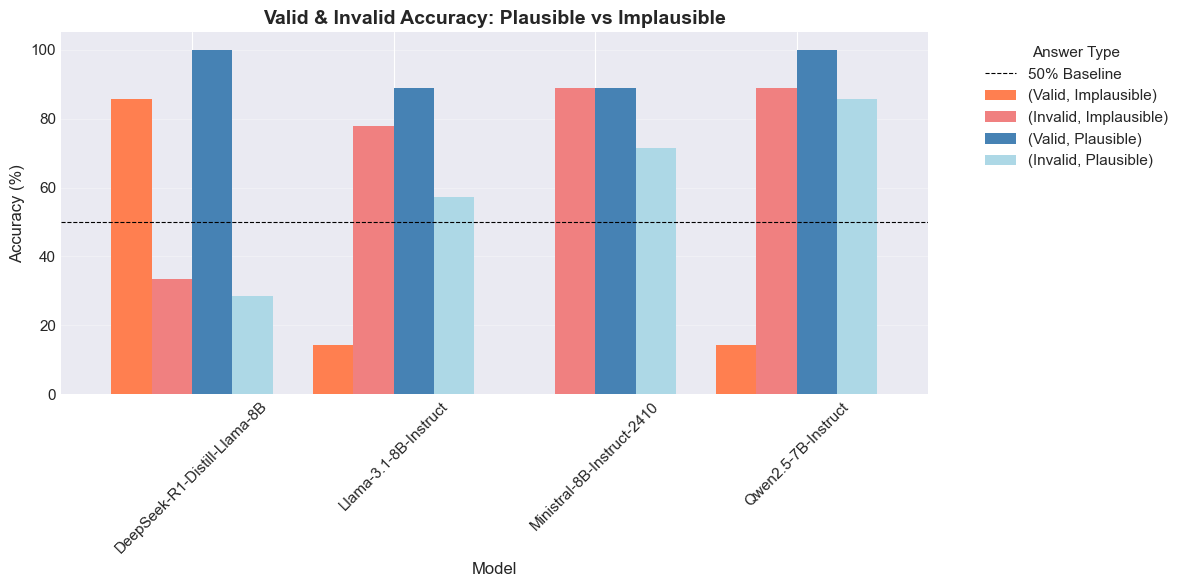

In [20]:
# Valid and Invalid Accuracy by Plausibility
print("\n\nValid and Invalid Accuracy by Plausibility:")
print("-" * 60)

# Check if plausibility data is available and prepare it
if 'plausibility' in df.columns:
    # Filter out NA values (both NaN and string 'NA')
    df_plausible = df[
        df['plausibility'].notna() & 
        (df['plausibility'].astype(str).str.upper() != 'NA')
    ].copy()
    
    if len(df_plausible) > 0:
        # Convert to binary if needed (plausible/implausible)
        if df_plausible['plausibility'].dtype == 'object':
            # Create binary column
            df_plausible['is_plausible'] = df_plausible['plausibility'].astype(str).str.lower().apply(
                lambda x: 1 if x == 'plausible' else (0 if x == 'implausible' else np.nan)
            )
            # Remove rows where plausibility is neither 'plausible' nor 'implausible'
            df_plausible = df_plausible[df_plausible['is_plausible'].notna()].copy()
        
        if len(df_plausible) > 0 and 'is_plausible' in df_plausible.columns:
            # Calculate accuracy for valid and invalid answers separately by plausibility
            accuracy_by_plaus = df_plausible.groupby(['model', 'is_plausible', 'correct_validity']).apply(
                lambda x: pd.Series({
                    'Valid_Accuracy': (x[x['correct_validity'] == 'valid']['is_correct']).mean() * 100 if len(x[x['correct_validity'] == 'valid']) > 0 else np.nan,
                    'Invalid_Accuracy': (x[x['correct_validity'] == 'invalid']['is_correct']).mean() * 100 if len(x[x['correct_validity'] == 'invalid']) > 0 else np.nan,
                    'Valid_Count': len(x[x['correct_validity'] == 'valid']),
                    'Invalid_Count': len(x[x['correct_validity'] == 'invalid'])
                })
            ).reset_index()
            
            # Create separate dataframes for valid and invalid accuracy
            valid_acc_by_plaus = accuracy_by_plaus.pivot_table(
                index='model', 
                columns='is_plausible', 
                values='Valid_Accuracy'
            )
            invalid_acc_by_plaus = accuracy_by_plaus.pivot_table(
                index='model', 
                columns='is_plausible', 
                values='Invalid_Accuracy'
            )
            
            # Rename columns for clarity
            rename_dict = {}
            if 0 in valid_acc_by_plaus.columns:
                rename_dict[0] = 'Implausible'
            if 1 in valid_acc_by_plaus.columns:
                rename_dict[1] = 'Plausible'
            
            if rename_dict:
                valid_acc_by_plaus = valid_acc_by_plaus.rename(columns=rename_dict)
                invalid_acc_by_plaus = invalid_acc_by_plaus.rename(columns=rename_dict)
            
            print("\nValid Answer Accuracy by Plausibility:")
            print(valid_acc_by_plaus.round(2))
            print("\nInvalid Answer Accuracy by Plausibility:")
            print(invalid_acc_by_plaus.round(2))
            
            # Visualization - Single plot showing valid and invalid separately by plausibility
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))
            
            # Create multi-level columns: (Answer_Type, Plausibility)
            plot_data = pd.DataFrame()
            for plaus_col in ['Implausible', 'Plausible']:
                if plaus_col in valid_acc_by_plaus.columns:
                    plot_data[('Valid', plaus_col)] = valid_acc_by_plaus[plaus_col]
                if plaus_col in invalid_acc_by_plaus.columns:
                    plot_data[('Invalid', plaus_col)] = invalid_acc_by_plaus[plaus_col]
            
            # Plot with grouped bars
            if len(plot_data.columns) > 0:
                plot_data.plot(kind='bar', ax=ax, color=['coral', 'lightcoral', 'steelblue', 'lightblue'], width=0.8)
                ax.axhline(y=50, color='black', linestyle='--', linewidth=0.8, label='50% Baseline')
                ax.set_xlabel('Model', fontsize=12)
                ax.set_ylabel('Accuracy (%)', fontsize=12)
                ax.set_title('Valid & Invalid Accuracy: Plausible vs Implausible', fontsize=14, fontweight='bold')
                ax.legend(title='Answer Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                ax.tick_params(axis='x', rotation=45)
                ax.grid(axis='y', alpha=0.3)
            else:
                ax.text(0.5, 0.5, 'No plausibility data available', 
                        ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Valid & Invalid Accuracy: Plausible vs Implausible', fontsize=14, fontweight='bold')
            
            plt.tight_layout()
            plt.show()
        else:
            print("\nNo valid plausibility data found (is_plausible column not created).")
    else:
        print("\nNo valid plausibility data found (all values are NA).")
else:
    print("\nNo 'plausibility' column found in the dataset.")

ADVANCED PLAUSIBILITY ANALYSIS: RESPONSE TIME AND FORM

1. Plausibility × Response Time Analysis
--------------------------------------------------------------------------------
Hypothesis: Plausible items may require different cognitive processing time

Response Time by Plausibility:
              mean  median    std  count
Implausible  4.512   2.290  4.989     64
Plausible    4.456   2.247  4.967     64

Statistical Test: equal variance t-test
  t(126) = -0.064, p = 0.9490, d = -0.011 - No significant difference

Response Time by Plausibility × Model:
                              Implausible  Plausible
model                                               
DeepSeek-R1-Distill-Llama-8B       11.828     11.834
Llama-3.1-8B-Instruct               3.119      3.197
Ministral-8B-Instruct-2410          1.485      1.353
Qwen2.5-7B-Instruct                 1.618      1.439

Two-Way ANOVA (Model × Plausibility) for Response Time:
                             sum_sq     df         F  PR(>F)
C(mo

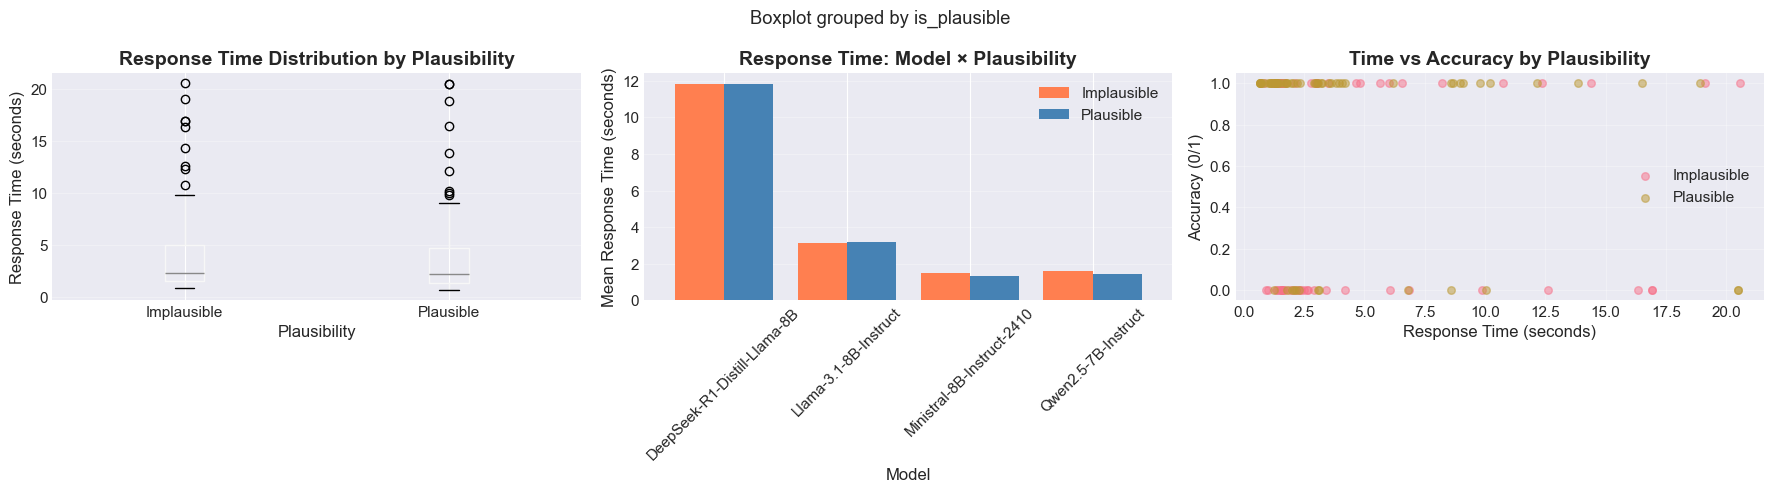



3. Plausibility × Syllogism Form Deep Analysis
--------------------------------------------------------------------------------

Performance by Form × Plausibility:
                      Accuracy    Std  Count  Mean_Time
form    is_plausible                                   
Darii   0                0.650  0.489     20      3.774
        1                0.917  0.282     24      5.015
Datisi  0                0.625  0.518      8      4.671
        1                0.875  0.354      8      3.762
Dimatis 0                0.450  0.510     20      5.952
        1                0.875  0.354      8      3.638
Disamis 0                0.375  0.518      8      4.318
        1                0.600  0.503     20      4.470
Sunny   0                0.500  0.535      8      2.794
        1                0.750  0.500      4      4.053

Two-Way ANOVA (Form × Plausibility):
                          sum_sq     df        F  PR(>F)
C(form)                   1.7692    4.0   2.1404  0.0801
C(is_plau

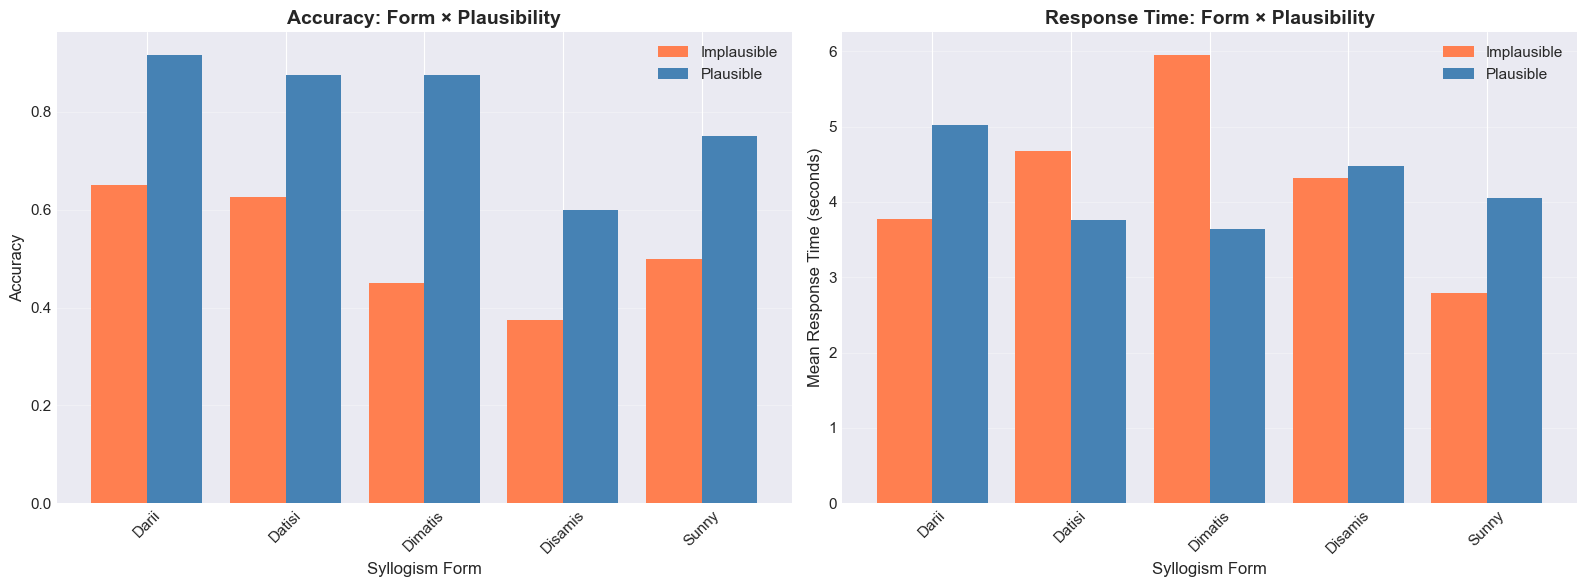



3. Comprehensive Model: Plausibility × All Variables
--------------------------------------------------------------------------------

Four-Way ANOVA: Model × Validity × Plausibility × Form

Key Interactions Involving Plausibility:
  is_plausible: F = 16.355, p = 0.0001 **
  model × is_plausible: F = 2.226, p = 0.0920
  correct_validity × is_plausible: F = 25.560, p = 0.0000 **
  is_plausible × form: F = 1.172, p = 0.3301
  model × correct_validity × is_plausible: F = 3.749, p = 0.0144 **
  model × is_plausible × form: F = 0.571, p = 0.8589


4. Summary: Plausibility Effects Summary Table
--------------------------------------------------------------------------------

Comprehensive Performance Summary:
                       model is_plausible correct_validity    form  Accuracy  N  Mean_Time  Valid_Answer_Rate
DeepSeek-R1-Distill-Llama-8B  Implausible          invalid   Darii     0.667  3      8.882             33.333
DeepSeek-R1-Distill-Llama-8B  Implausible          invalid  Datis

In [16]:
# 13. Advanced Plausibility Analysis: Response Time and Form Interactions
print("=" * 80)
print("ADVANCED PLAUSIBILITY ANALYSIS: RESPONSE TIME AND FORM")
print("=" * 80)

if plausibility_available and len(df_plausible) > 0 and 'is_plausible' in df_plausible.columns:
    
    # 1. Plausibility × Response Time Analysis (Cognitive Load Hypothesis)
    print("\n1. Plausibility × Response Time Analysis")
    print("-" * 80)
    print("Hypothesis: Plausible items may require different cognitive processing time")
    
    # Descriptive statistics
    time_by_plaus = df_plausible.groupby('is_plausible')['time'].agg(['mean', 'median', 'std', 'count']).round(3)
    time_by_plaus.index = ['Implausible', 'Plausible']
    print("\nResponse Time by Plausibility:")
    print(time_by_plaus)
    
    # Statistical test
    plausible_time = df_plausible[df_plausible['is_plausible'] == 1]['time']
    implausible_time = df_plausible[df_plausible['is_plausible'] == 0]['time']
    
    if len(plausible_time) > 1 and len(implausible_time) > 1:
        # Check variance equality
        _, p_levene = stats.levene(plausible_time, implausible_time)
        if p_levene > 0.05:
            t_stat, p_val = stats.ttest_ind(plausible_time, implausible_time, equal_var=True)
            test_type = "equal variance t-test"
        else:
            t_stat, p_val = stats.ttest_ind(plausible_time, implausible_time, equal_var=False)
            test_type = "Welch's t-test"
        
        # Calculate Cohen's d
        pooled_std = np.sqrt(((len(plausible_time)-1)*plausible_time.std()**2 + 
                             (len(implausible_time)-1)*implausible_time.std()**2) / 
                            (len(plausible_time)+len(implausible_time)-2))
        cohens_d = (plausible_time.mean() - implausible_time.mean()) / pooled_std if pooled_std > 0 else 0
        
        print(f"\nStatistical Test: {test_type}")
        print(f"  t({len(plausible_time)+len(implausible_time)-2}) = {t_stat:.3f}, p = {p_val:.4f}, d = {cohens_d:.3f}", end="")
        if p_val < 0.05:
            print(" ** Significant difference")
        else:
            print(" - No significant difference")
    
    # Response time by plausibility for each model
    print("\nResponse Time by Plausibility × Model:")
    time_model_plaus = df_plausible.groupby(['model', 'is_plausible'])['time'].agg(['mean', 'std']).round(3)
    time_model_plaus_pivot = time_model_plaus['mean'].unstack()
    time_model_plaus_pivot.columns = ['Implausible', 'Plausible']
    print(time_model_plaus_pivot)
    
    # Two-way ANOVA: Plausibility × Model for response time
    try:
        model_time = ols('time ~ C(model) + C(is_plausible) + C(model):C(is_plausible)', 
                        data=df_plausible).fit()
        anova_time = anova_lm(model_time, typ=2)
        print("\nTwo-Way ANOVA (Model × Plausibility) for Response Time:")
        print(anova_time[['sum_sq', 'df', 'F', 'PR(>F)']].round(4))
        
        if 'C(model):C(is_plausible)' in anova_time.index:
            interaction_f = anova_time.loc['C(model):C(is_plausible)', 'F']
            interaction_p = anova_time.loc['C(model):C(is_plausible)', 'PR(>F)']
            sig = " **" if interaction_p < 0.05 else ""
            print(f"\nModel × Plausibility Interaction: F = {interaction_f:.3f}, p = {interaction_p:.4f}{sig}")
    except Exception as e:
        print(f"Error in response time ANOVA: {e}")
    
    # Correlation: Response time and accuracy within plausibility levels
    print("\nCorrelation: Response Time vs Accuracy by Plausibility")
    for plaus_level in [0, 1]:
        plaus_label = 'Implausible' if plaus_level == 0 else 'Plausible'
        plaus_df = df_plausible[df_plausible['is_plausible'] == plaus_level]
        if len(plaus_df) > 3:
            r, p_corr = stats.pearsonr(plaus_df['time'], plaus_df['is_correct'])
            print(f"  {plaus_label}: r = {r:.3f}, p = {p_corr:.4f}", end="")
            if p_corr < 0.05:
                print(" ** Significant correlation")
            else:
                print(" - No significant correlation")
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Response time distribution by plausibility
    df_plausible.boxplot(column='time', by='is_plausible', ax=axes[0])
    axes[0].set_title('Response Time Distribution by Plausibility', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Plausibility', fontsize=12)
    axes[0].set_ylabel('Response Time (seconds)', fontsize=12)
    axes[0].set_xticklabels(['Implausible', 'Plausible'])
    axes[0].grid(axis='y', alpha=0.3)
    
    # Plot 2: Response time by model and plausibility
    time_model_plaus_pivot.plot(kind='bar', ax=axes[1], color=['coral', 'steelblue'], width=0.8)
    axes[1].set_title('Response Time: Model × Plausibility', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Model', fontsize=12)
    axes[1].set_ylabel('Mean Response Time (seconds)', fontsize=12)
    axes[1].legend(['Implausible', 'Plausible'])
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Plot 3: Scatter plot: Time vs Accuracy by plausibility
    for plaus_level in [0, 1]:
        plaus_label = 'Implausible' if plaus_level == 0 else 'Plausible'
        plaus_df = df_plausible[df_plausible['is_plausible'] == plaus_level]
        axes[2].scatter(plaus_df['time'], plaus_df['is_correct'], 
                       alpha=0.5, label=plaus_label, s=30)
    axes[2].set_xlabel('Response Time (seconds)', fontsize=12)
    axes[2].set_ylabel('Accuracy (0/1)', fontsize=12)
    axes[2].set_title('Time vs Accuracy by Plausibility', fontsize=14, fontweight='bold')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
 
   

        
    # 3. Plausibility × Syllogism Form Deep Analysis
    print("\n\n3. Plausibility × Syllogism Form Deep Analysis")
    print("-" * 80)
    
    if 'form' in df_plausible.columns:
        # Detailed breakdown
        form_plaus_perf = df_plausible.groupby(['form', 'is_plausible']).agg({
            'is_correct': ['mean', 'std', 'count'],
            'time': 'mean'
        }).round(3)
        form_plaus_perf.columns = ['Accuracy', 'Std', 'Count', 'Mean_Time']
        print("\nPerformance by Form × Plausibility:")
        print(form_plaus_perf)
        
        # Two-way ANOVA: Plausibility × Form
        try:
            model_form_plaus = ols('is_correct ~ C(form) + C(is_plausible) + C(form):C(is_plausible)', 
                                  data=df_plausible).fit()
            anova_form_plaus = anova_lm(model_form_plaus, typ=2)
            print("\nTwo-Way ANOVA (Form × Plausibility):")
            print(anova_form_plaus[['sum_sq', 'df', 'F', 'PR(>F)']].round(4))
            
            if 'C(form):C(is_plausible)' in anova_form_plaus.index:
                interaction_f = anova_form_plaus.loc['C(form):C(is_plausible)', 'F']
                interaction_p = anova_form_plaus.loc['C(form):C(is_plausible)', 'PR(>F)']
                sig = " **" if interaction_p < 0.05 else ""
                print(f"\nForm × Plausibility Interaction: F = {interaction_f:.3f}, p = {interaction_p:.4f}{sig}")
        except Exception as e:
            print(f"Error in Form × Plausibility ANOVA: {e}")
        
        # Simple effects: Plausibility effect within each form
        print("\nSimple Effects: Plausibility Effect Within Each Form")
        for form in df_plausible['form'].unique():
            form_df = df_plausible[df_plausible['form'] == form]
            plausible_acc = form_df[form_df['is_plausible'] == 1]['is_correct']
            implausible_acc = form_df[form_df['is_plausible'] == 0]['is_correct']
            
            if len(plausible_acc) > 1 and len(implausible_acc) > 1:
                t_stat, p_val = stats.ttest_ind(plausible_acc, implausible_acc)
                pooled_std = np.sqrt(((len(plausible_acc)-1)*plausible_acc.std()**2 + 
                                     (len(implausible_acc)-1)*implausible_acc.std()**2) / 
                                    (len(plausible_acc)+len(implausible_acc)-2))
                cohens_d = (plausible_acc.mean() - implausible_acc.mean()) / pooled_std if pooled_std > 0 else 0
                
                print(f"\n  {form}:")
                print(f"    Plausible: M = {plausible_acc.mean():.3f}, N = {len(plausible_acc)}")
                print(f"    Implausible: M = {implausible_acc.mean():.3f}, N = {len(implausible_acc)}")
                print(f"    t = {t_stat:.3f}, p = {p_val:.4f}, d = {cohens_d:.3f}", end="")
                if p_val < 0.05:
                    print(" **")
                else:
                    print()
        
        # Visualization
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Accuracy by Form × Plausibility
        form_plaus_pivot = df_plausible.groupby(['form', 'is_plausible'])['is_correct'].mean().unstack()
        form_plaus_pivot.columns = ['Implausible', 'Plausible']
        form_plaus_pivot.plot(kind='bar', ax=axes[0], color=['coral', 'steelblue'], width=0.8)
        axes[0].set_xlabel('Syllogism Form', fontsize=12)
        axes[0].set_ylabel('Accuracy', fontsize=12)
        axes[0].set_title('Accuracy: Form × Plausibility', fontsize=14, fontweight='bold')
        axes[0].legend(['Implausible', 'Plausible'])
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(axis='y', alpha=0.3)
        
        # Plot 2: Response time by Form × Plausibility
        form_plaus_time = df_plausible.groupby(['form', 'is_plausible'])['time'].mean().unstack()
        form_plaus_time.columns = ['Implausible', 'Plausible']
        form_plaus_time.plot(kind='bar', ax=axes[1], color=['coral', 'steelblue'], width=0.8)
        axes[1].set_xlabel('Syllogism Form', fontsize=12)
        axes[1].set_ylabel('Mean Response Time (seconds)', fontsize=12)
        axes[1].set_title('Response Time: Form × Plausibility', fontsize=14, fontweight='bold')
        axes[1].legend(['Implausible', 'Plausible'])
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    # 3. Comprehensive Model: All Variables Together
    print("\n\n3. Comprehensive Model: Plausibility × All Variables")
    print("-" * 80)
    
    try:
        # Four-way ANOVA: Model × Validity × Plausibility × Form
        if 'form' in df_plausible.columns:
            print("\nFour-Way ANOVA: Model × Validity × Plausibility × Form")
            model_4way = ols('is_correct ~ C(model) + C(correct_validity) + C(is_plausible) + C(form) + '
                            'C(model):C(correct_validity) + C(model):C(is_plausible) + C(model):C(form) + '
                            'C(correct_validity):C(is_plausible) + C(correct_validity):C(form) + '
                            'C(is_plausible):C(form) + '
                            'C(model):C(correct_validity):C(is_plausible) + '
                            'C(model):C(is_plausible):C(form)', 
                            data=df_plausible).fit()
            anova_4way = anova_lm(model_4way, typ=2)
            
            # Extract key interactions involving plausibility
            print("\nKey Interactions Involving Plausibility:")
            plaus_interactions = [idx for idx in anova_4way.index if 'is_plausible' in idx]
            for interaction in plaus_interactions:
                f_val = anova_4way.loc[interaction, 'F']
                p_val = anova_4way.loc[interaction, 'PR(>F)']
                interaction_name = interaction.replace('C(', '').replace(')', '').replace(':', ' × ')
                sig = " **" if p_val < 0.05 else ""
                print(f"  {interaction_name}: F = {f_val:.3f}, p = {p_val:.4f}{sig}")
    except Exception as e:
        print(f"Error in comprehensive model: {e}")
        import traceback
        traceback.print_exc()
    
    # 4. Summary: Plausibility Effects Across All Variables
    print("\n\n4. Summary: Plausibility Effects Summary Table")
    print("-" * 80)
    
    # Create comprehensive summary
    summary_vars = ['model', 'is_plausible', 'correct_validity']
    if 'form' in df_plausible.columns:
        summary_vars.append('form')
    
    comprehensive_summary = df_plausible.groupby(summary_vars).agg({
        'is_correct': ['mean', 'count'],
        'time': 'mean',
        'llm_answer': lambda x: (x == 'valid').sum() / len(x) * 100
    }).round(3)
    comprehensive_summary.columns = ['Accuracy', 'N', 'Mean_Time', 'Valid_Answer_Rate']
    comprehensive_summary = comprehensive_summary.reset_index()
    comprehensive_summary['is_plausible'] = comprehensive_summary['is_plausible'].map({0: 'Implausible', 1: 'Plausible'})
    
    print("\nComprehensive Performance Summary:")
    print(comprehensive_summary.to_string(index=False))
    
    # Export to CSV
    comprehensive_summary.to_csv('results/plausibility_comprehensive_analysis.csv', index=False)
    print("\n✓ Comprehensive summary saved to 'results/plausibility_comprehensive_analysis.csv'")
    
else:
    print("\nCannot perform advanced plausibility analysis - insufficient plausibility data.")

print("\n" + "=" * 80)
